<a href="https://colab.research.google.com/github/TaylorShiehUSI/Github-Colab-test/blob/main/military_aircraft_image_classification_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 下載資料




In [1]:
! pip install -q kaggle #install kaggle to get the data

In [2]:
from google.colab import files

files.upload() #Upload your kaggle.json to get the authority to download the data. As for how to get kaggle.json, please check https://kai-huang.medium.com/%E6%9C%80%E9%BD%8A%E5%85%A8%E7%9A%84-kaggle-api-%E4%B8%AD%E6%96%87%E6%89%8B%E5%86%8A-%E4%B8%80-84c01174deb5

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"taylorshieh","key":"82ddb164ddaeeafb0d6690909cb58be1"}'}

In [3]:
# To make a directory named .kaggle, then put kaggle.json in it. 
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [4]:
! kaggle datasets download -d a2015003713/militaryaircraftdetectiondataset #Download the dataset.

100% 7.75G/7.77G [01:10<00:00, 163MB/s]
100% 7.77G/7.77G [01:10<00:00, 119MB/s]


In [5]:
#Make a directory named militaryaircraftdetectiondataset unzip the dataset to it. 
! mkdir militaryaircraftdetectiondataset
! unzip militaryaircraftdetectiondataset.zip -d militaryaircraftdetectiondataset

串流輸出內容已截斷至最後 5000 行。
  inflating: militaryaircraftdetectiondataset/dataset/b3d482af48b877f1801f330144998ea8.csv  
  inflating: militaryaircraftdetectiondataset/dataset/b3d482af48b877f1801f330144998ea8.jpg  
  inflating: militaryaircraftdetectiondataset/dataset/b3d5731e46a60940855c91eebe802ba7.csv  
  inflating: militaryaircraftdetectiondataset/dataset/b3d5731e46a60940855c91eebe802ba7.jpg  
  inflating: militaryaircraftdetectiondataset/dataset/b3d5ab77feb1db2d5273a28b46e5b13a.csv  
  inflating: militaryaircraftdetectiondataset/dataset/b3d5ab77feb1db2d5273a28b46e5b13a.jpg  
  inflating: militaryaircraftdetectiondataset/dataset/b3e47e7eb9343faf3de68636b70e91cb.csv  
  inflating: militaryaircraftdetectiondataset/dataset/b3e47e7eb9343faf3de68636b70e91cb.jpg  
  inflating: militaryaircraftdetectiondataset/dataset/b3e85ee853fca18f5516d27570af1a54.csv  
  inflating: militaryaircraftdetectiondataset/dataset/b3e85ee853fca18f5516d27570af1a54.jpg  
  inflating: militaryaircraftdetectiondataset/dat

# 準備及分割資料集

In [6]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import pathlib
import tensorflow as tf
from tensorflow.keras import layers, losses, optimizers, applications
from tensorflow.keras.utils import image_dataset_from_directory, plot_model
import numpy as np
import matplotlib.pyplot as plt

In [7]:
# Load dataset
FILE_DIR = "./militaryaircraftdetectiondataset/crop/"
DATA_PATH = pathlib.Path(FILE_DIR)

In [8]:
#Check the data is correct or not.
SEED = 12345
IMG_SIZE = (128, 128)
BATCH_SIZE = 40
train_data = image_dataset_from_directory(DATA_PATH,
                                          validation_split=0.3,
                                          subset='training',
                                          seed=SEED,
                                          shuffle=True,
                                          image_size=IMG_SIZE,
                                          batch_size=BATCH_SIZE
                                          )

validation_data = image_dataset_from_directory(DATA_PATH,
                                               validation_split=0.3,
                                               subset='validation',
                                               seed=SEED,
                                               shuffle=True,
                                               image_size=IMG_SIZE,
                                               batch_size=BATCH_SIZE)

Found 13869 files belonging to 40 classes.
Using 9709 files for training.
Found 13869 files belonging to 40 classes.
Using 4160 files for validation.


In [9]:
# Split validation_data into validation & test set
val_batches = tf.data.experimental.cardinality(validation_data)
test_data = validation_data.take(val_batches//5)
val_data = validation_data.skip(val_batches//5)

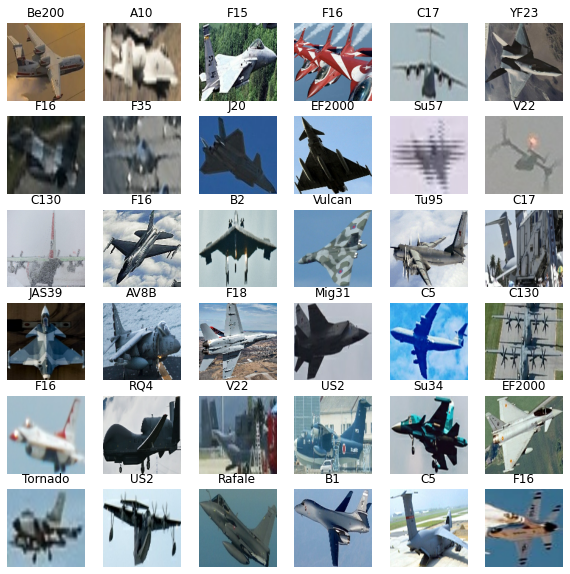

In [10]:
# Display examples of data
class_names = train_data.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
    for i in range(36):
        ax = plt.subplot(6, 6, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [11]:
# Create prefetch for train,test,val data
AUTOTUNE = tf.data.AUTOTUNE
pf_train = train_data.prefetch(buffer_size=AUTOTUNE)
pf_test = test_data.prefetch(buffer_size=AUTOTUNE)
pf_val = val_data.prefetch(buffer_size=AUTOTUNE)

In [12]:
# Augmentation layer
data_augmentation = tf.keras.Sequential()
data_augmentation.add(layers.RandomFlip('horizontal_and_vertical'))
data_augmentation.add(layers.RandomRotation(0.4))

# 模型部分(這部分可以自由調整，請研究什麼模型及參數或方法效果最好)

In [13]:
# Feature extraction layer
# (a) Input processing
preprocess_input = applications.resnet50.preprocess_input

# (b) create base model using ResNet50
IMG_SHAPE = IMG_SIZE + (3,)
base_model = applications.ResNet50(input_shape=IMG_SHAPE,
                                   include_top=False,
                                   weights='imagenet')

# (c) Freeze layers
base_model.trainable = False
base_model.summary()

# (d) Classification layer
nClass = len(class_names)

global_avg = layers.GlobalAveragePooling2D()
output_layer = layers.Dense(nClass, activation='softmax')

94765736/94765736 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 64, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalizat

In [14]:
# Chain layers with Functional api
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
x = preprocess_input(inputs)
x = base_model(x)
x = global_avg(x)
outputs = output_layer(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 128, 128, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 128, 128, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 40)                81960 

In [15]:
# Compile model
lr_schedule = optimizers.schedules.CosineDecay(0.001, 500)
optimizer = optimizers.Adam(learning_rate=lr_schedule)
loss = losses.SparseCategoricalCrossentropy()

model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [ ]:
# Train Model
EPOCHS = 8
history = model.fit(pf_train, validation_data=(pf_val), epochs=EPOCHS)

Epoch 1/8
243/243 [==============================] - 18s 72ms/step - loss: 1.3804 - accuracy: 0.6227 - val_loss: 1.9702 - val_accuracy: 0.4640
Epoch 2/8
243/243 [==============================] - 18s 72ms/step - loss: 1.3804 - accuracy: 0.6227 - val_loss: 1.9603 - val_accuracy: 0.4676
Epoch 3/8
243/243 [==============================] - 18s 72ms/step - loss: 1.3804 - accuracy: 0.6227 - val_loss: 1.9596 - val_accuracy: 0.4655


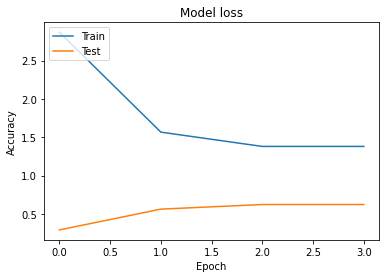

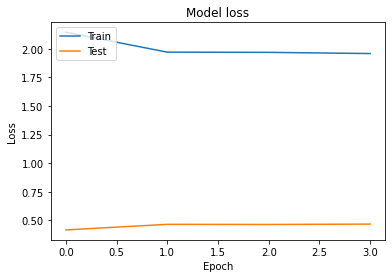

In [21]:
#Plot the loss and Accuracy
#import matplotlib.pyplot as plt

# history = model.fit(x, y, validation_split=0.25, epochs=50, batch_size=16, verbose=1)

# 绘制训练 & 验证的准确率值
plt.plot(history.history['loss'])
plt.plot(history.history['accuracy'])
plt.title('Model loss')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# 绘制训练 & 验证的损失值
plt.plot(history.history['val_loss'])
plt.plot(history.history['val_accuracy'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()



In [49]:
# Finetune layer of base model
base_model.trainable = True
for layer in base_model.layers[:100]:
    layer.trainable = False

# Recompile model
optimizer = optimizers.RMSprop(learning_rate=lr_schedule)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [50]:
# Continue model training
fine_tune_epoch = 1
NEW_EPOCH = EPOCHS + fine_tune_epoch

history_fine = model.fit(pf_train,
                         validation_data=(pf_val),
                         epochs=NEW_EPOCH,
                         initial_epoch=history.epoch[-1])

Epoch 1/2
243/243 [==============================] - 25s 78ms/step - loss: 1.8197 - accuracy: 0.5131 - val_loss: 4.1536 - val_accuracy: 0.3842
Epoch 2/2
243/243 [==============================] - 19s 75ms/step - loss: 0.2798 - accuracy: 0.9238 - val_loss: 0.6566 - val_accuracy: 0.8143


save model

In [61]:
# Calling `save('my_model')` creates a SavedModel folder `my_model`.
model.save("airclassifier")

In [62]:
!ls

 airclassifier		    kaggle.json
 classifier_test	    militaryaircraftdetectiondataset
'classifier_test (1).zip'   militaryaircraftdetectiondataset.zip
 classifier_test.zip	    sample_data
'kaggle (1).json'


# 預測部分(以test dataset來做預測，因此可用此部分結果觀察模型好壞)

In [51]:
# Make predictions
image_batch, label_batch = pf_test.as_numpy_iterator().next()
predicted_labels = np.argmax(model.predict(image_batch), axis=1)

2/2 [==============================] - 1s 11ms/step


In [52]:
# Compare label against predictions
label_vs_prediction = np.transpose(np.vstack((label_batch, predicted_labels)))
print(label_vs_prediction)

[[19 19]
 [33 33]
 [ 4  4]
 [24  7]
 [34 34]
 [ 2  8]
 [19 19]
 [17 17]
 [35 35]
 [36 36]
 [16 16]
 [39 39]
 [31 31]
 [37 37]
 [36 36]
 [28 28]
 [19 21]
 [18 18]
 [17 17]
 [21 21]
 [ 0 15]
 [19 19]
 [ 8  8]
 [19 19]
 [36 36]
 [ 5  5]
 [21 21]
 [16 16]
 [31 31]
 [37 37]
 [ 3  3]
 [35 20]
 [24 24]
 [17 14]
 [18 18]
 [ 9  9]
 [12 12]
 [17 17]
 [37 37]
 [15 17]]


# 上傳期末專題所需要預測的十張圖片

In [53]:
from google.colab import files

files.upload()

Saving classifier_test.zip to classifier_test (1).zip


{'classifier_test.zip': b'PK\x03\x04\n\x00\x00\x00\x00\x00\x8f\xb6\x8aU\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x10\x00\x00\x00classifier_test/PK\x03\x04\x14\x00\x00\x00\x08\x00"}vU3\x7f\x1b\x00\xdai\x0e\x00*{\x0e\x00\x18\x00\x00\x00classifier_test/0001.jpg\xac\xfawTSM\xf47\x8e&\x84\xd0K\xc0\xd0[\xa8\x86P\xa4\x83\xf0\xa0\tU)\x9a@\xe8\x1d)\nH3\xc0#(B\xa8\x82\x14\x91" \x1a\x82\x81\x10z\x90\x16\x1eP@\x94"\x08B\x80\x88\x11\xf1\x01\x0c\x11\xa3\x0fR\x04D\xaf\xdf\xf7\xbd\xeb\xbe\xbfu\xef\xfa\xfd\xf1[\xeb\xeeYs\xe6s\xf6\x9e\xb5\xf7\xec}f\xe6\xcc>\xeb\xfc^\xfa\xfd\x01\x00q\xb0;o\x07\x00\x02\x01\x00\xe0\x9f\x02\xf8\xfd\x91\x0b~\xde\xda:\x00\xedr\xd1\xee\xbc\x93\xed\xff\x12pI\x03\xfe\x10\xb7\x1e\x00p5\x1a\x17\xefbo\x05\xf3\xf4\xf2\x86\x01\xfe/\x14t\xe9Z,\xe0\xff\x9e\xfe\xe8\xd8[\xf8\x9f+\x000\xa7\x03\xf8\x7fN\xfc!\xa1\xd7.\xfdi\xbf\xfd\xa9\xb8\xf8?\xc6\xff\xa8\x0c\xf9\x83\xa1\xe1\xff\x1b\xff\xfd?8\xf8\x7f\xe3;\xff\x83\xe3\xb1.\xd6\x7f0\xe1\x0f\x86\x87\xff_p\xf0\xff\x05\'\xe1bq\x7f\xf0\xd8

In [54]:
! mkdir classifier_test
! unzip classifier_test.zip -d classifier_test

Archive:  classifier_test.zip
  inflating: classifier_test/group.xlsx  
  inflating: classifier_test/0001.jpg  
  inflating: classifier_test/0002.jpg  
  inflating: classifier_test/0003.jpg  
  inflating: classifier_test/0004.jpg  
  inflating: classifier_test/0005.jpg  
  inflating: classifier_test/0006.jpg  
  inflating: classifier_test/0007.jpg  
  inflating: classifier_test/0008.jpg  
  inflating: classifier_test/0009.jpg  
  inflating: classifier_test/0010.jpg  


In [ ]:
!ls

classifier_test.zip  militaryaircraftdetectiondataset	   sample_data
kaggle.json	     militaryaircraftdetectiondataset.zip


In [58]:
FILE_DIR = "./classifier_test"
DATA_PATH = pathlib.Path(FILE_DIR)
# DATA_PATH = ./classifier_test.Path(FILE_DIR)

# image_dataset_from_directory(
#     DATA_PATH,
#     validation_split=0.3,
#     subset='training',
#     seed=SEED,
#     shuffle=True,
#     image_size=IMG_SIZE,
#     batch_size=BATCH_SIZE
#     )

ans_data = image_dataset_from_directory(DATA_PATH, image_size=IMG_SIZE, shuffle=False)

pf_ans = ans_data.prefetch(buffer_size=AUTOTUNE)

Found 10 files belonging to 11 classes.


In [59]:
image_batch, _ = pf_ans.as_numpy_iterator().next()
predicted_labels = np.argmax(model.predict(image_batch), axis=1)

1/1 [==============================] - 0s 170ms/step


In [60]:
# Print out the result, and you should output a file contain image name and your predictions.
file_paths = [item[-8:] for item in ans_data.file_paths]
result = np.transpose(np.vstack((file_paths,predicted_labels)))
print(result)

[['0001.jpg' '1']
 ['0002.jpg' '3']
 ['0003.jpg' '14']
 ['0004.jpg' '8']
 ['0005.jpg' '12']
 ['0006.jpg' '16']
 ['0007.jpg' '13']
 ['0008.jpg' '31']
 ['0009.jpg' '23']
 ['0010.jpg' '19']]
